# Problem Statement

Prepare solution to build ticketing system there by using json file as your primary datasource (Text corpus with other metadata in it). 
Step 1: Group data into five categories namely Banking services, loans, Fraudalent reporting, Card, others.
Step 2: From step 1 create labeled dataset and utilize it to train supervised model like logistic regression, decision tree or random forest.


Above excercise should follow these steps -
Load Data
Text Preprocessing
EDA
Feature Extraction
Topic Modelling (Unsupervised)
Model building using Supervised learning
Model Training and evaluation
Inference

# Solutioning

We need to build a model that is able to classify Customer Complaints based on the products/services. By doing so you can segregate these tickets into their relevant categories.

As data is not labeled, apply NMF to analyse patterns and classify the tickets into the following 5 clusters based on the products/services.

- **Credit/Prepaid Card**
- **Bank Account Services**
- **Theft/Dispute Reporting**
- **Mortgages/Loans**
- **Others**

# Approach

## Steps: 
* 1. Import libraries 
* 2. Perform EDA  
* 3. Pre-process data 
* 4. Topic modelling 
* 5. Identify the n best topics 
* 6. Map complaints to topics 
* 7. Create labelled dataset for supervised learning 
* 8. Train-test split of data 9.Train model on various algorithm 
* 10. Select the best model 
* 11. Classify any new customer complaint ticket with the trained model

# Import Required Libraries and Modules

In [366]:
# Builtin libraries
import os
import warnings
import json
import re
import string
import IPython as ipy
import pickle
import pprint

# libraries for machine learning 
import numpy as np
import pandas as pd
# import matplotlib as mpl 
import seaborn as sns
# import plotly
import sklearn as skl 
import json

# NLP libraries
import nltk
import spacy
# import en_core_web_sm
import textblob
import wordcloud
import gensim
import string

In [367]:
warnings.filterwarnings(action='ignore')

In [368]:
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from matplotlib import pyplot as plt 

from sklearn.model_selection import train_test_split as tts 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import decomposition as decomp
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models import nmf, CoherenceModel 
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

In [370]:
# !python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

# Loading Input (JSON) Data as DataFrame

In [371]:
with open("./Client_data.json") as f_handle:
    input_data = json.load(f_handle)
input_df = pd.json_normalize(input_data)
input_df.head(3)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided


# Text Pre-processing

Steps:

* Remove blanks
* Lowecase text 
* Remove square brackets
* Remove punctuation
* Remove words containing numbers
* Lemmatize texts
* POS tagging -extract relevant words


In [372]:
#Size of the dataset
input_df.shape

(78313, 22)

In [373]:
#Information about the dataframe (column names,column length, datatypes and if they contain null records)
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

#### *Observation: We see non-null values for every column. Column '_source.company_public_response'  has only 4 records so can be ignored for further exploration.*

In [374]:
input_df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [375]:
#Choosing only the necessary columns - '_source.product','_source.sub_product','_source.complaint_what_happened' from source dataframe

complain_df = input_df[['_source.product','_source.sub_product','_source.complaint_what_happened']]
complain_df.shape

(78313, 3)

In [376]:
#Renaming the columns

complain_df = complain_df.rename(columns={'_source.complaint_what_happened': 'Complaint', '_source.product': 'Category','_source.sub_product': 'Sub_Category' })
complain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Category      78313 non-null  object
 1   Sub_Category  67742 non-null  object
 2   Complaint     78313 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [377]:
complain_df.head()

,Category,Sub_Category,Complaint
0,Debt collection,Credit card debt,
1,Debt collection,Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,General-purpose credit card or charge card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,Conventional home mortgage,
4,Credit card or prepaid card,General-purpose credit card or charge card,


In [378]:
# merging the category and sub-category columns
complain_df['Category'] = complain_df['Category'] + '+' + complain_df['Sub_Category']
complain_df1 = complain_df.copy()
complain_df = complain_df.drop(['Sub_Category'],axis=1)
complain_df.head()

,Category,Complaint
0,Debt collection+Credit card debt,
1,Debt collection+Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card+General-purpose cr...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage+Conventional home mortgage,
4,Credit card or prepaid card+General-purpose cr...,


#### *Observation: For 'Complaint' column - There are a few records with missing values. We will drop them. We will replace null values with nan.*

In [380]:
# finding out the number of empty strings in complaint column
len(complain_df[complain_df['Complaint'] == ''])

57241

In [381]:
#Replacing the empty comments with Nan
complain_df[complain_df['Complaint'] == ''] = np.nan
complain_df['Complaint'].isnull().sum()

57241

In [382]:
# Dropping the columns with null values
complain_df = complain_df[~complain_df.Complaint.isnull()]
complain_df['Complaint'].isnull().sum()

0

In [383]:
#Dropping missing values
complain_df.dropna(inplace=True)
complain_df.shape

(18963, 2)

In [384]:
complain_df.head()

,Category,Complaint
1,Debt collection+Credit card debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card+General-purpose cr...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,"Credit reporting, credit repair services, or o...",Chase Card was reported on XX/XX/2019. However...
11,"Credit reporting, credit repair services, or o...","On XX/XX/2018, while trying to book a XXXX XX..."
14,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...


#### *Observation: The dataype is object for Complaint column. Converting it to string datatype.There are 'XXX' in some complaints. Replacing it with ''.*

In [385]:
complain_df['Complaint']=complain_df['Complaint'].astype(str)
complain_df['Complaint'] = complain_df['Complaint'].str.replace('X', '')

In [388]:
#Cleaning Text- This function will convert text in lower case, removing text in square brackets, removing punctuations, removing words containing numbers
def processtext(issue_df):
    issue_df=issue_df.lower()
    issue_df=re.sub(r'\[.*?\]',"",issue_df)
    issue_df=re.sub(r'\w*\d\w*',"",issue_df)
    issue_df=re.sub(r'[%s]'% re.escape(string.punctuation),"",issue_df)
    return issue_df.strip()

complain_df['Complaints_Clean']=complain_df['Complaint'].apply(lambda x:processtext(x))


In [389]:
# Function to create lemmatized text
def text_lemma(complaint):
    sent=[]
    doc=nlp(complaint)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

complain_df['Complains_Lemmatized']= complain_df.apply(lambda x:text_lemma(x['Complaints_Clean']),axis=1)

In [390]:
complain_df.head()

,Category,Complaint,Complaints_Clean,Complains_Lemmatized
1,Debt collection+Credit card debt,Good morning my name is and I appreciate it ...,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...
2,Credit card or prepaid card+General-purpose cr...,I upgraded my card in //2018 and was told by...,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...
10,"Credit reporting, credit repair services, or o...","Chase Card was reported on //2019. However, fr...",chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,"Credit reporting, credit repair services, or o...","On //2018, while trying to book a ticket, ...",on while trying to book a ticket i came a...,on while try to book a ticket I come ac...
14,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [391]:
# POS tagging
def extract_pos_tags(complaint_lemma):
    doc = nlp(complaint_lemma)
    sent = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(sent)

In [392]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
complain_df['Complains_Tag'] =  complain_df.Complains_Lemmatized.apply(lambda x: extract_pos_tags(x))
complain_df

,Category,Complaint,Complaints_Clean,Complains_Lemmatized,Complains_Tag
1,Debt collection+Credit card debt,Good morning my name is and I appreciate it ...,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...,morning name stop debt verification statement ...
2,Credit card or prepaid card+General-purpose cr...,I upgraded my card in //2018 and was told by...,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...,card agent upgrade anniversary date agent info...
10,"Credit reporting, credit repair services, or o...","Chase Card was reported on //2019. However, fr...",chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,"Credit reporting, credit repair services, or o...","On //2018, while trying to book a ticket, ...",on while trying to book a ticket i came a...,on while try to book a ticket I come ac...,ticket offer ticket reward card information of...
14,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...
...,...,...,...,...,...
78301,Checking or savings account+Checking account,My husband passed away. Chase bank put check o...,my husband passed away chase bank put check on...,my husband pass away chase bank put check on h...,husband check hold rent car insurance negative...
78303,Credit card or prepaid card+General-purpose cr...,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,Credit card or prepaid card+General-purpose cr...,"On Wednesday, // I called Chas, my Visa Cred...",on wednesday i called chas my visa credit c...,on wednesday I call cha my visa credit ca...,visa credit card provider claim purchase prote...
78310,Checking or savings account+Checking account,I am not familiar with pay and did not unders...,i am not familiar with pay and did not unders...,I be not familiar with pay and do not unders...,risk consumer chase bank app chase year bankin...


# EDA

Steps:

* Vizualizing the complains
* Wordcloud
* Creating ngrams - unigram, bigram, trigram
* Seperating first 40 issues
* Distribution of the 40 issues

In [394]:
# Vizualization of Issues 
complain_df.Complains_Tag

1        morning name stop debt verification statement ...
2        card agent upgrade anniversary date agent info...
10       card report application identity consent servi...
11       ticket offer ticket reward card information of...
14       son chase account fund chase bank account mone...
                               ...                        
78301    husband check hold rent car insurance negative...
78303    chase card customer decade solicitation credit...
78309    visa credit card provider claim purchase prote...
78310    risk consumer chase bank app chase year bankin...
78311    credit yrs chase credit card freedom problem b...
Name: Complains_Tag, Length: 18963, dtype: object

(-0.5, 399.5, 199.5, -0.5)

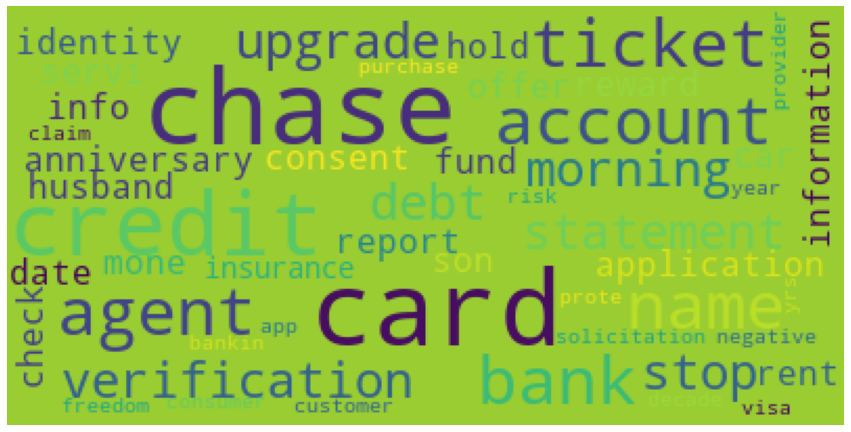

In [395]:
#Word Cloud

# from wordcloud import WordCloud, STOPWORDS

wordcloud= WordCloud(collocations = False, 
                     background_color = 'yellowgreen', 
                     stopwords=set(STOPWORDS), 
                     max_words=50, 
                     max_font_size=50, 
                     random_state=40).generate(str(complain_df['Complains_Tag']))

fig=plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [396]:
# Function to extract top ngrams(unigram/bigram/trigram)
def ngrams(text, n=None, ngram=(1,3)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [397]:
top_40words = ngrams(complain_df['Complains_Tag'].values.astype('U'), n=40, ngram=(1,3))
df_ngram = pd.DataFrame(top_40words, columns=['ngram', 'count'])

# top 15 unigrams and their frequency
df_ngram.head(15)

,ngram,count
0,account,43997
1,chase,32446
2,credit,27705
3,card,24806
4,payment,19313
5,bank,18519
6,time,14761
7,check,12510
8,charge,12302
9,day,12105


<Figure size 720x1080 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Top 40 issues in complaints')

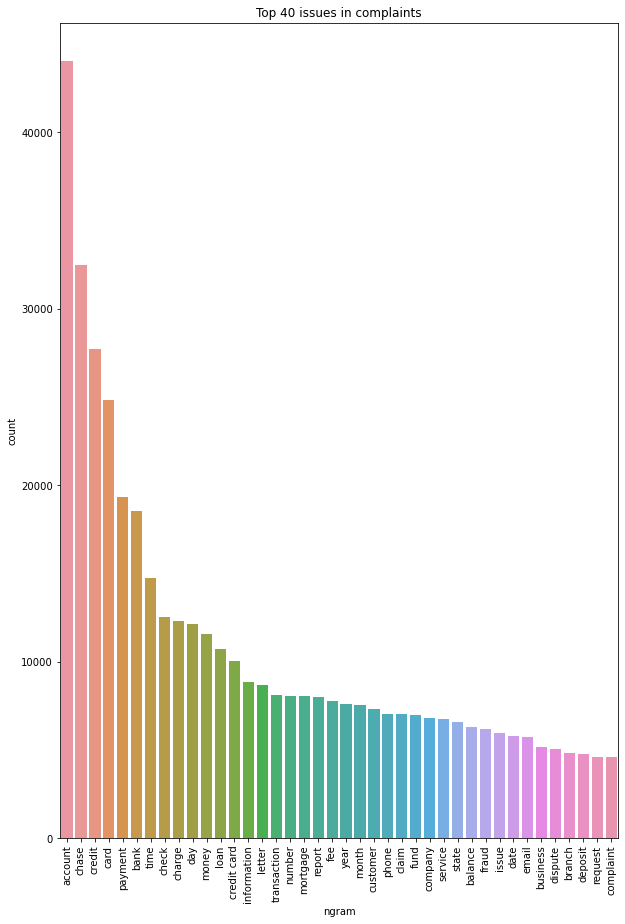

In [398]:
#Visual distribution of top 40 complains issues
plt.figure(figsize=[10,15])
plt.xticks(rotation=90)
fig = sns.barplot(x=df_ngram['ngram'], y=df_ngram['count'])
plt.title('Top 40 issues in complaints')
plt.show()

# Feature Engineering

Steps:

* TF-IDF (vectorizing data)
* Document term matrix

In [399]:
#TF-IDF
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [400]:
#Creating document term matrix
doc_term_matrix = tfidf.fit_transform(complain_df['Complains_Tag'])

# Topic Modelling

Steps:

Optimal number of topics (Gensim - NMF)
* Spliting the text
* Creating dictionary (mapping words to id)
* Setting boundaries - (Remove words with length<3, keepping the dictionary size to 6000, limiting the word frequency to 85%)
* Creating BOW corpus
* Set topic range from 1 to 10
* Calculate the coherence score for each topic
* Compare the coherence score and get the optimum number of topics

Topic Modelling with NMF
* set the optimal topic number
* Load NMF model
* Fit document term matrix
* Find out the words composition in each topic 
* Label the topic to its most coherent form
* Map the document and topic

In [401]:
# Use Gensim's NMF to get the best number of topics via coherence score
texts = complain_df['Complains_Tag']
data = [d.split() for d in texts]
# Creating dictionary (mapping words and their integer id)
dictionary = Dictionary(data)
# Remove words with length<3, keepping the dictionary size to 6000, limiting the word frequency to 80%
dictionary.filter_extremes(no_below=3,no_above=0.85,keep_n=6000)
# Create BOW - (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in data]
# Range of topics
topic_nums = list(np.arange(5, 10, 1))

# Nmf model - cCoherence score for each topic
coherence_scores = []
for num in topic_nums:
    nmf = Nmf(corpus=corpus, num_topics=num, id2word=dictionary, chunksize=2000, passes=5,kappa=.1, minimum_probability=0.01, 
              w_max_iter=300, w_stop_condition=0.0001, h_max_iter=100, h_stop_condition=0.001, eval_every=10, normalize=True, random_state=42)
    # Coherence model will calculate the score
    cm = CoherenceModel(model=nmf,texts=texts,dictionary=dictionary,coherence='c_v')
    coherence_scores.append(round(cm.get_coherence(), 5))
      
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
optimum_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
print(optimum_topics)

5


In [402]:
# from sklearn.decomposition import NMF

In [403]:
#Load nmf model with the n_components = 5
num_topics = 5

#keeping the random_state = 40
nmf_model = NMF(n_components=num_topics, random_state=40)

#NMF model
W1 = nmf_model.fit(doc_term_matrix)
len(tfidf.get_feature_names())

6472

In [404]:
H1 = nmf_model.components_
H1

array([[7.90468923e-04, 0.00000000e+00, 0.00000000e+00, ...,
        1.54595591e-03, 0.00000000e+00, 5.83129257e-04],
       [0.00000000e+00, 4.27356299e-03, 0.00000000e+00, ...,
        1.28326245e-03, 3.72786967e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.21715773e-03, 0.00000000e+00, 3.97282610e-03],
       [2.51845281e-04, 3.75954054e-03, 0.00000000e+00, ...,
        6.01917670e-03, 0.00000000e+00, 1.98221796e-03],
       [4.29780891e-05, 6.73323481e-05, 1.35520489e-03, ...,
        3.89889279e-03, 9.19175357e-04, 3.11469761e-03]])

In [405]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H1[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,deposit,chase,branch,day,transaction,number,business,transfer,fee,claim
Topic 2,credit,report,inquiry,card,account,score,company,reporting,information,debt,bureaus,identity,application,theft,limit
Topic 3,payment,month,balance,fee,statement,time,day,auto,credit,chase,mortgage,date,car,account,year
Topic 4,card,charge,chase,credit,transaction,dispute,purchase,fee,fraud,merchant,service,claim,time,company,debit
Topic 5,loan,mortgage,home,modification,chase,property,year,rate,letter,document,time,foreclosure,house,sale,request


#### *Observation: The below topics are apparent as main topics.*

- 1.   Banking  Services
- 2.   Card - Prepaid or Postpaid
- 3.   Others
- 4.   Fraud Reporting
- 5.   Loans/Mortgage

In [406]:
# Assigning the best topic to each complain
doc_topic = nmf_model.transform(doc_term_matrix)
complain_df['Topic'] = doc_topic.argmax(axis = 1)
complain_df.head()

,Category,Complaint,Complaints_Clean,Complains_Lemmatized,Complains_Tag,Topic
1,Debt collection+Credit card debt,Good morning my name is and I appreciate it ...,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...,morning name stop debt verification statement ...,4
2,Credit card or prepaid card+General-purpose cr...,I upgraded my card in //2018 and was told by...,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...,card agent upgrade anniversary date agent info...,3
10,"Credit reporting, credit repair services, or o...","Chase Card was reported on //2019. However, fr...",chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,"Credit reporting, credit repair services, or o...","On //2018, while trying to book a ticket, ...",on while trying to book a ticket i came a...,on while try to book a ticket I come ac...,ticket offer ticket reward card information of...,1
14,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,0


In [407]:
#Mapping topic names and Topics
Topic_names = {
    0:"Banking services",
    1:"Card - Prepaid or Postpaid", 
    2:"Others",
    3:"Fraud Reporting",
    4:"Loans/Mortgage"
}

#Map Topics with Topic Names
complain_df['Domain_Topic'] = complain_df['Topic'].map(Topic_names)
complain_df.head()

,Category,Complaint,Complaints_Clean,Complains_Lemmatized,Complains_Tag,Topic,Domain_Topic
1,Debt collection+Credit card debt,Good morning my name is and I appreciate it ...,good morning my name is and i appreciate it ...,good morning my name be and I appreciate it...,morning name stop debt verification statement ...,4,Loans/Mortgage
2,Credit card or prepaid card+General-purpose cr...,I upgraded my card in //2018 and was told by...,i upgraded my card in and was told by the a...,I upgrade my card in and be tell by the a...,card agent upgrade anniversary date agent info...,3,Fraud Reporting
10,"Credit reporting, credit repair services, or o...","Chase Card was reported on //2019. However, fr...",chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1,Card - Prepaid or Postpaid
11,"Credit reporting, credit repair services, or o...","On //2018, while trying to book a ticket, ...",on while trying to book a ticket i came a...,on while try to book a ticket I come ac...,ticket offer ticket reward card information of...,1,Card - Prepaid or Postpaid
14,Checking or savings account+Checking account,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,0,Banking services


<AxesSubplot:>

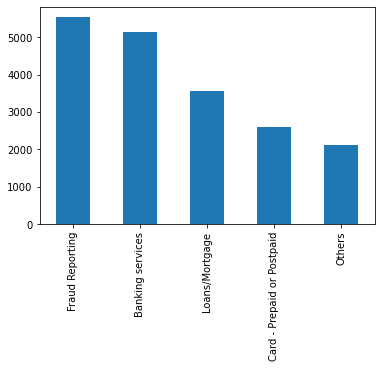

In [425]:
# Checking the topic distribution across the dataset
complain_df['Domain_Topic'].value_counts().plot.bar()

### *Observation: There is a clear class imbalance between the different classes.*

## Training the model

Steps:

Train - Test split
* create the labelled data
* X - Labelled data
* Y - Targets
* Split the data into training and testing data - 80:30 split

Supervised Learning
* Load different classification models
* Fit and transform the training data
* Ensure to handle the class imbalance problem in the data
* Train the data 
* Predict the classes
* Check the confusion metrics parameters - f1 score, precision, recall
* Select the best model

Supervised - Classification Models
* Logistic Regression
* Naive Bayes
* Decision Tree
* Random forest 

In [410]:
#Training dataset - into X and Y
X = complain_df["Complains_Tag"]
Y = complain_df["Topic"]

#Count Vectorizer
vect = CountVectorizer()
X_train_cntvec = vect.fit_transform(X)

#TFIDF transformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cntvec)


In [411]:
## Test train split - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, Y, test_size=0.20, random_state=40)

In [412]:
##Confusion Matrix for classification models
target_topics = list(complain_df.Domain_Topic.unique())

def confusionmatrix(X_test, y_test, model):
    target_topics = list(complain_df.Domain_Topic.unique())
    predicted = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test,predicted)
    print("\t\t\tConfusion Matrix Evaluation report")
    print("\n")
    print(classification_report(y_test, predicted, target_names=target_topics))
    print("Overall Model score", reg_models.score(X_test,y_test))

### Supervised training models without handling the class imbalance

In [413]:
# Logistic regression model
reg_models = LogisticRegression(random_state=40, penalty='l2',class_weight=None,multi_class='auto').fit(X_train,y_train)
confusionmatrix(X_test, y_test, reg_models)

			Confusion Matrix Evaluation report


                            precision    recall  f1-score   support

            Loans/Mortgage       0.95      0.98      0.97       996
           Fraud Reporting       0.97      0.95      0.96       524
Card - Prepaid or Postpaid       0.97      0.91      0.94       417
          Banking services       0.96      0.97      0.96      1121
                    Others       0.95      0.95      0.95       735

                  accuracy                           0.96      3793
                 macro avg       0.96      0.95      0.96      3793
              weighted avg       0.96      0.96      0.96      3793

Overall Model score 0.9583443184814131


In [414]:
# Multinomial Naive Bayes for classification
clf = MultinomialNB().fit(X_train, y_train)
confusionmatrix(X_test, y_test, clf)

			Confusion Matrix Evaluation report


                            precision    recall  f1-score   support

            Loans/Mortgage       0.79      0.90      0.84       996
           Fraud Reporting       0.89      0.56      0.69       524
Card - Prepaid or Postpaid       0.93      0.16      0.27       417
          Banking services       0.69      0.90      0.78      1121
                    Others       0.79      0.85      0.82       735

                  accuracy                           0.76      3793
                 macro avg       0.82      0.67      0.68      3793
              weighted avg       0.79      0.76      0.73      3793

Overall Model score 0.9583443184814131


In [415]:
# Decision tree classifier
decision_tree_classifier =  DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
confusionmatrix(X_test, y_test, decision_tree_classifier)

			Confusion Matrix Evaluation report


                            precision    recall  f1-score   support

            Loans/Mortgage       0.84      0.86      0.85       996
           Fraud Reporting       0.79      0.81      0.80       524
Card - Prepaid or Postpaid       0.79      0.80      0.79       417
          Banking services       0.86      0.85      0.85      1121
                    Others       0.87      0.85      0.86       735

                  accuracy                           0.84      3793
                 macro avg       0.83      0.83      0.83      3793
              weighted avg       0.84      0.84      0.84      3793

Overall Model score 0.9583443184814131


In [416]:
# Random forest classifier
random_forest_classifier = RandomForestClassifier(random_state=42).fit(X_train, y_train)
confusionmatrix(X_test, y_test, random_forest_classifier)

			Confusion Matrix Evaluation report


                            precision    recall  f1-score   support

            Loans/Mortgage       0.83      0.94      0.89       996
           Fraud Reporting       0.88      0.82      0.85       524
Card - Prepaid or Postpaid       0.93      0.55      0.69       417
          Banking services       0.86      0.90      0.88      1121
                    Others       0.88      0.91      0.89       735

                  accuracy                           0.86      3793
                 macro avg       0.88      0.82      0.84      3793
              weighted avg       0.87      0.86      0.86      3793

Overall Model score 0.9583443184814131


### Supervised training models without handling the class imbalance

In [417]:
# Sampling the data to handle the class imbalance problem
from sklearn.model_selection import StratifiedKFold
stratifiedfolds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)

In [418]:
# Function for GridSearchCV object
def cv_gridsearch(model,stratifiedfolds,params,scoring):
    
    grid_search = GridSearchCV(model,
                                cv=stratifiedfolds, 
                                param_grid=params, 
                                scoring=scoring, 
                                n_jobs=-1, verbose=1)
    return grid_search

#### The Gridsearch CV process is computation instensive. Hence performing it for Logistic regression only.

In [423]:
# Logistic Regression with GridSearchCV
log_reg_model = LogisticRegression()

# List of hyperparameter for Logistic Regression
reg_model_params = {
              'C': [0.01, 1, 10], 
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear','newton-cg','saga']
             }

# Gridsearch 
grid_search_logreg = cv_gridsearch(log_reg_model, stratifiedfolds, reg_model_params, scoring=None)
# fit model
grid_search_logreg.fit(X_train, y_train)

# Classification Report
confusionmatrix(X_test, y_test, grid_search_logreg)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/home/shritid/Apps/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shritid/Apps/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shritid/Apps/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shritid/Apps/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shritid/Apps/miniconda3/envs/nlp/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=40, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'saga']},
             verbose=1)

			Confusion Matrix Evaluation report


                            precision    recall  f1-score   support

            Loans/Mortgage       0.98      0.98      0.98       996
           Fraud Reporting       0.98      0.99      0.98       524
Card - Prepaid or Postpaid       0.97      0.96      0.97       417
          Banking services       0.98      0.98      0.98      1121
                    Others       0.97      0.97      0.97       735

                  accuracy                           0.98      3793
                 macro avg       0.98      0.98      0.98      3793
              weighted avg       0.98      0.98      0.98      3793

Overall Model score 0.9583443184814131


# Conclusion

### We can see there are 5 topics in the document.
### There is a class imbalance problem between the classess.
### The best classification model is Logistic regression (before treating the class imbalace problem).
### The score to judge the best model performance is F1 score for every class as it takes the harmonic mean between precision and recall 